In [1]:
import math
import torch
import torchvision
import time
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim
%matplotlib inline

In [2]:
def rmsprop_2d(x1,x2,s1,s2):
    g1,g2,eps=0.2*x1,4*x2,1e-6
    s1=gamma * s1 + (1-gamma)* g1 **2
    s2=gamma * s2 + (1-gamma) * g2 **2
    x1 -=eta / math.sqrt(s1+eps) * g1
    x2 -=eta/math.sqrt(s2+eps) * g2
    return x1,x2,s1,s2
    
def f_2d(x1,x2):
    return 0.1*x1**2+2*x2**2
    

In [20]:
def train_2d(trainer):
    x1,x2,s1,s2=-5,-2,0,0
    result=[(x1,x2)]
    for i in range(20):
        x1,x2,s1,s2=trainer(x1,x2,s1,s2)
#         trainer(x1,x2,s1,s2)
        result.append((x1,x2))
    return result

def show_trace_2d(f,result):
    plt.plot(*zip(*result),'ro-')
    x1,x2=np.meshgrid(np.arange(-5.5,1.0,0.1),np.arange(-3.0,1.0,0.1))
    plt.contour(x1,x2,f(x1,x2))
    plt.xlabel('x1')
    plt.ylabel('y2')
    

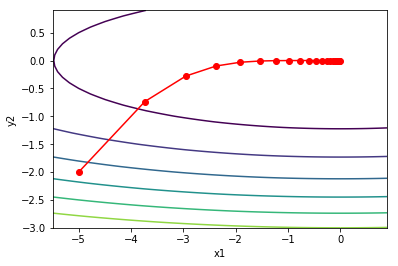

In [21]:
eta,gamma=0.4,0.9
show_trace_2d(f_2d,train_2d(rmsprop_2d))

In [10]:
def get_data_ch7():
    data=np.genfromtxt(r'F:\study\ml\DataSet\airfoil_self_noise\airfoil_self_noise.dat',
                      delimiter='\t')
    data=(data-data.mean(axis=0)) / data.std(axis=0)
    features=torch.tensor(data[:1500,:-1],dtype=torch.float32)
    labels=torch.tensor(data[:1500,-1],dtype=torch.float32)
    return features,labels

In [11]:
features,labels=get_data_ch7()
features.shape

torch.Size([1500, 5])

In [28]:
def linreg(x,w,b):
    return torch.mm(x,w)+b
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.shape))**2

In [55]:
def init_rmsprop_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)


def rmsprop(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s.data += hyperparams['gamma'] * s.data + (1 - hyperparams['gamma']) * (
            p.grad.data)**2
        p.data -= hyperparams['lr'] / torch.sqrt(s.data + eps) * p.grad.data

In [56]:
def train_ch7(optimizer_fun,
              states,
              hyperparams,
              features,
              labels,
              batch_size=10,
              num_epochs=2):

    net, loss = linreg, squared_loss
    w = nn.Parameter(
        torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)),
                     dtype=torch.float32,
                     requires_grad=True))
    b = nn.Parameter(
        torch.tensor(np.zeros(1), dtype=torch.float32, requires_grad=True))
    
    def eval_loss():
        return loss(net(features,w,b),labels).mean().item() /2
    
    ls=[eval_loss()]
    
    data_iter=torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(features,labels),batch_size=batch_size,
    shuffle=True)
    
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            l=loss(net(X,w,b),y).mean() /2
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            optimizer_fun([w,b],states,hyperparams)
            if (batch_i+1) * batch_size % 100  ==0:
                ls.append(eval_loss())
    print('loss : %f, %f sec per epoch' % (ls[-1],time.time()-start))
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel('epochs')
    plt.ylabel('loss')

loss : 0.436197, 0.067004 sec per epoch


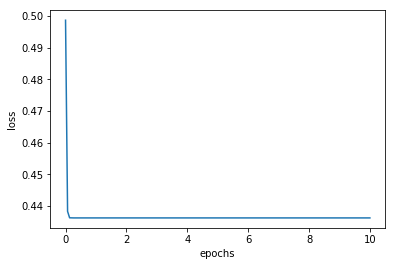

In [72]:
train_ch7(rmsprop,
          init_rmsprop_states(), {
              'lr': 0.01,
              'gamma': 0.9
          },
          features,
          labels,
          batch_size=10,
          num_epochs=10)

In [73]:
def train_pytorch_ch7(optimizer_fn,
                      hyperparams,
                      features,
                      labels,
                      batch_size=10,
                      num_epochs=2):
    net = nn.Sequential(nn.Linear(features.shape[1], 1))
    loss = nn.MSELoss()
    
#     print(features.shape)
#     print('eval shape : ',net(features).view(-1).shape)
    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]

    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
        features, labels),
                                            batch_size=batch_size,
                                            shuffle=True)
    optimizer=optimizer_fn(net.parameters(),**hyperparams)
    
    for _ in range(num_epochs):
        start=time.time()
        for batch_i ,(X,y) in enumerate(data_iter):
            l=loss(net(X).view(-1),y) /2
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i+1) * batch_size % 100  ==0:
                ls.append(eval_loss())
    print('loss : %f, %f sec per epoch' % (ls[-1],time.time()-start))
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel('epochs')
    plt.ylabel('loss')
            
            
            

loss : 0.246998, 0.052003 sec per epoch


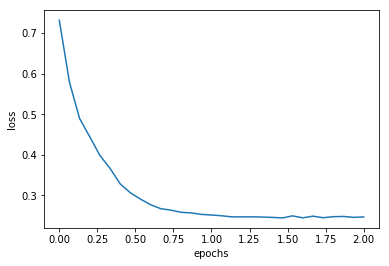

In [70]:
train_pytorch_ch7(torch.optim.RMSprop, {
              'lr': 0.01,
              'alpha': 0.9
          },
          features,
          labels)